In [12]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

import qiskit.tools.jupyter


import numpy as np

# %matplotlib inline
# %qiskit_job_watcher

# Variations of Relative Phase Toffoli Gate

In this notebook, we'll compare two different implementations of relative phase 3-bit toffoli gate. The first implementation will be from Aqua `rccx` gate and another will be from ... on multiple real devices to see their differences. 

In this experiment we'll apply the relative phase Toffoli gate twice with initial input of $\left|110\right\rangle$ (or in Qiskit invention 011)

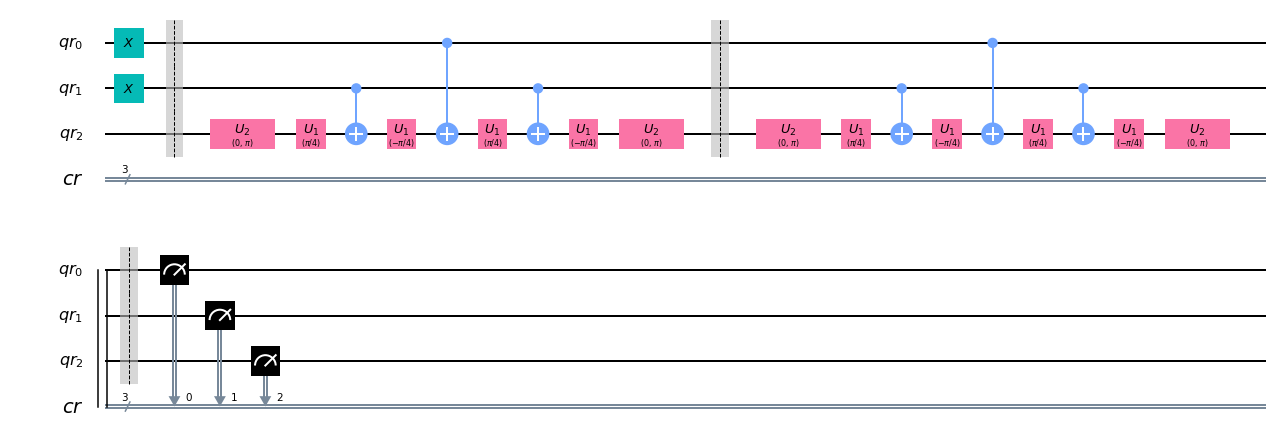

In [7]:
qr = QuantumRegister(3, 'qr')
cr = ClassicalRegister(3, 'cr')

qiskit_rccx_circuit = QuantumCircuit(qr, cr)
qiskit_rccx_circuit.x([qr[0], qr[1]])
qiskit_rccx_circuit.barrier()
qiskit_rccx_circuit.rccx(qr[0], qr[1], qr[2])
qiskit_rccx_circuit.barrier()
qiskit_rccx_circuit.rccx(qr[0], qr[1], qr[2])
qiskit_rccx_circuit.barrier()
qiskit_rccx_circuit.measure(qr, cr)

qiskit_rccx_circuit.draw(output='mpl')

In [8]:
def _rccx(self, a, b, c):
    self.ry(np.pi/4, c)
    self.cx(b, c)
    self.ry(np.pi/4, c)
    self.cx(a, c)
    self.ry(-np.pi/4, c)
    self.cx(b, c)
    self.ry(-np.pi/4, c)
    
QuantumCircuit._rccx = _rccx

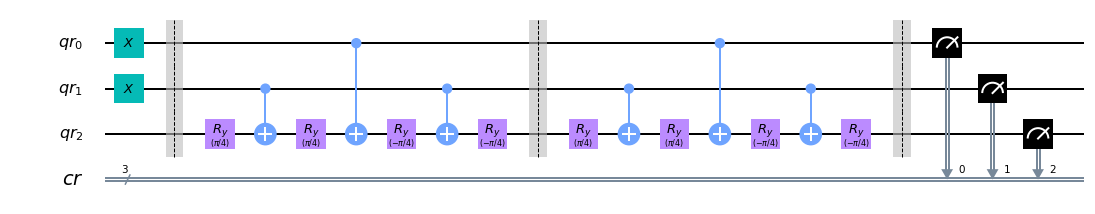

In [9]:

qr = QuantumRegister(3, 'qr')
cr = ClassicalRegister(3, 'cr')

my_rccx_circuit = QuantumCircuit(qr, cr)
my_rccx_circuit.x([qr[0], qr[1]])
my_rccx_circuit.barrier()
my_rccx_circuit._rccx(qr[0], qr[1], qr[2])
my_rccx_circuit.barrier()
my_rccx_circuit._rccx(qr[0], qr[1], qr[2])
my_rccx_circuit.barrier()
my_rccx_circuit.measure(qr, cr)

my_rccx_circuit.draw(output='mpl')

In [10]:
provider = IBMQ.load_account()

## Test with Melbourne Device

In [15]:
melbourne_device = provider.get_backend('ibmq_16_melbourne')
job = qiskit.execute([qiskit_rccx_circuit, my_rccx_circuit], backend=melbourne_device, shots=8192)

In [13]:
job_monitor(job)

Job Status: job has successfully run


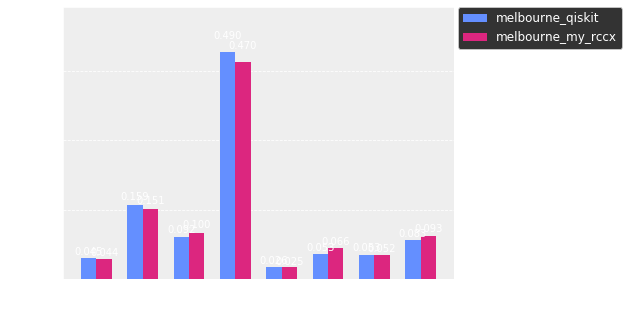

In [18]:
melbourne_result = job.result()
melbourne_qiskit_counts = melbourne_result.get_counts(qiskit_rccx_circuit)
melbourne_myrccx_counts = melbourne_result.get_counts(my_rccx_circuit)
plot_histogram([melbourne_qiskit_counts, melbourne_myrccx_counts], legend=['melbourne_qiskit', 'melbourne_my_rccx'])

## Try with Ourense Device

In [19]:
ourense_device = provider.get_backend('ibmq_ourense')
job = qiskit.execute([qiskit_rccx_circuit, my_rccx_circuit], backend=ourense_device, shots=8192)
job_monitor(job)

Job Status: job has successfully run


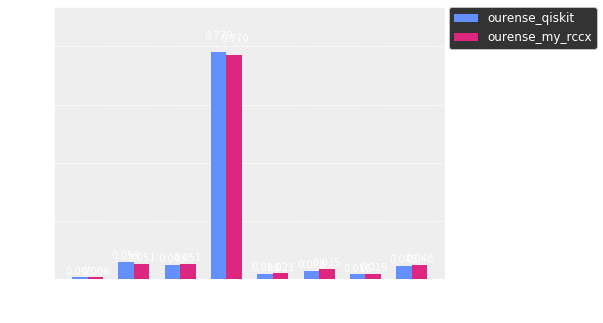

In [20]:
ourense_result = job.result()
ourense_qiskit_counts = ourense_result.get_counts(qiskit_rccx_circuit)
ourense_myrccx_counts = ourense_result.get_counts(my_rccx_circuit)
plot_histogram([ourense_qiskit_counts, ourense_myrccx_counts], legend=['ourense_qiskit', 'ourense_my_rccx'])

## Try with Vigo Device

In [21]:
vigo_device = provider.get_backend('ibmq_vigo')
job = qiskit.execute([qiskit_rccx_circuit, my_rccx_circuit], backend=vigo_device, shots=8192)
job_monitor(job)

Job Status: job has successfully run


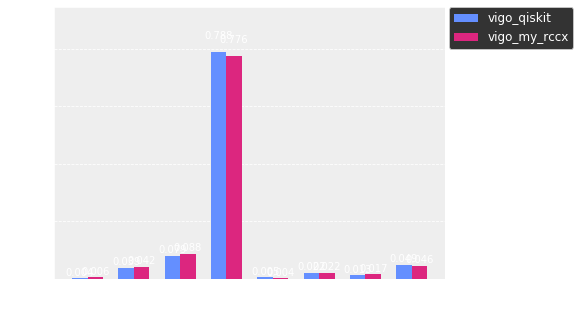

In [22]:
vigo_result = job.result()
vigo_qiskit_counts = vigo_result.get_counts(qiskit_rccx_circuit)
vigo_myrccx_counts = vigo_result.get_counts(my_rccx_circuit)
plot_histogram([vigo_qiskit_counts, vigo_myrccx_counts], legend=['vigo_qiskit', 'vigo_my_rccx'])

## Try with Yorktown Device

In [23]:
yorktown_device = provider.get_backend('ibmqx2')
job = qiskit.execute([qiskit_rccx_circuit, my_rccx_circuit], backend=yorktown_device, shots=8192)
job_monitor(job)

Job Status: job has successfully run


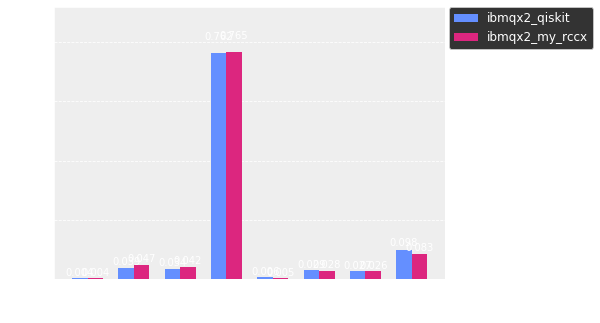

In [24]:
ibmqx2_result = job.result()
ibmqx2_qiskit_counts = ibmqx2_result.get_counts(qiskit_rccx_circuit)
ibmqx2_myrccx_counts = ibmqx2_result.get_counts(my_rccx_circuit)
plot_histogram([ibmqx2_qiskit_counts, ibmqx2_myrccx_counts], legend=['ibmqx2_qiskit', 'ibmqx2_my_rccx'])

## Now let's compare the same design across devices

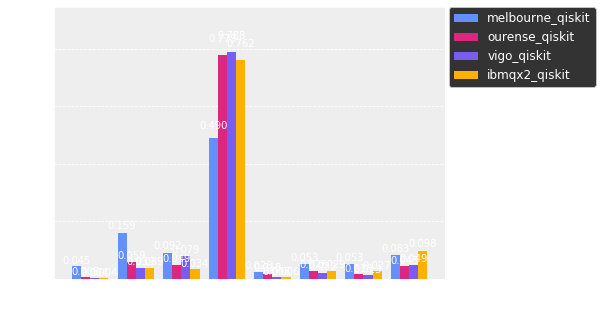

In [29]:
device_names = ['melbourne', 'ourense', 'vigo', 'ibmqx2']
qiskit_rccx_counts = [globals()[d+'_qiskit_counts'] for d in device_names]
legends = [d+'_qiskit' for d in device_names]
plot_histogram(qiskit_rccx_counts, legend=legends)

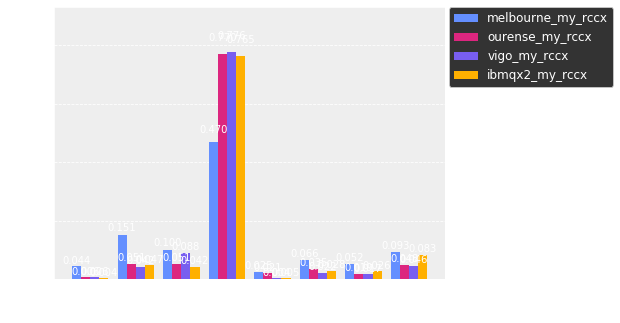

In [31]:
device_names = ['melbourne', 'ourense', 'vigo', 'ibmqx2']
qiskit_rccx_counts = [globals()[d+'_myrccx_counts'] for d in device_names]
legends = [d+'_my_rccx' for d in device_names]
plot_histogram(qiskit_rccx_counts, legend=legends)

## Let's apply error mitigation on measurement

In [39]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

cal_circuits, state_labels = complete_meas_cal(qr=qiskit_rccx_circuit.qregs[0], 
                                               circlabel='measurement_calibration')

In [42]:
melbourne_cal_job = qiskit.execute(cal_circuits,
             backend=melbourne_device,
             shots=8192,
             optimization_level=0)
print(melbourne_cal_job.job_id())
job_monitor(melbourne_cal_job)

5da60b7e27f430001270d5ce
Job Status: job has successfully run


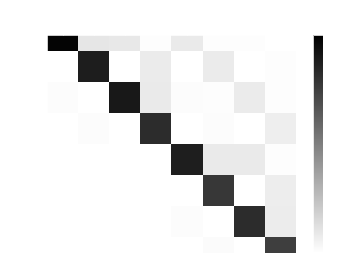

In [45]:
melbourne_cal_results = melbourne_cal_job.result()
melbourne_meas_fitter = CompleteMeasFitter(melbourne_cal_results, state_labels)
melbourne_meas_fitter.plot_calibration()

In [44]:
ourense_cal_job = qiskit.execute(cal_circuits,
             backend=ourense_device,
             shots=8192,
             optimization_level=0)
print(ourense_cal_job.job_id())
job_monitor(ourense_cal_job)

5da60c2c3c1181001284df64
Job Status: job has successfully run


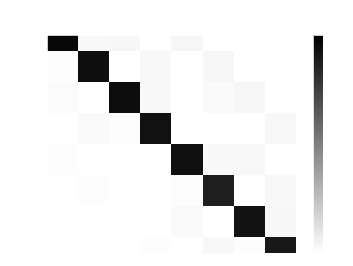

In [46]:
ourense_cal_results = ourense_cal_job.result()
ourense_meas_fitter = CompleteMeasFitter(ourense_cal_results, state_labels)
ourense_meas_fitter.plot_calibration()

In [47]:
vigo_cal_job = qiskit.execute(cal_circuits,
             backend=vigo_device,
             shots=8192,
             optimization_level=0)
print(vigo_cal_job.job_id())
job_monitor(vigo_cal_job)

5da60d403c1181001284df69
Job Status: job has successfully run


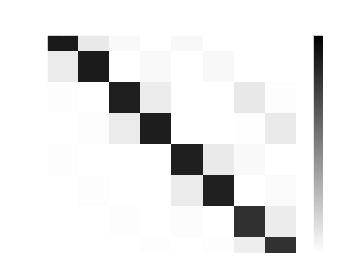

In [48]:
vigo_cal_results = vigo_cal_job.result()
vigo_meas_fitter = CompleteMeasFitter(vigo_cal_results, state_labels)
vigo_meas_fitter.plot_calibration()

In [50]:
yorktown_cal_job = qiskit.execute(cal_circuits,
             backend=yorktown_device,
             shots=8192,
             optimization_level=0)
print(yorktown_cal_job.job_id())
job_monitor(yorktown_cal_job)

5da60e7ebeb3350011051bf5
Job Status: job has successfully run


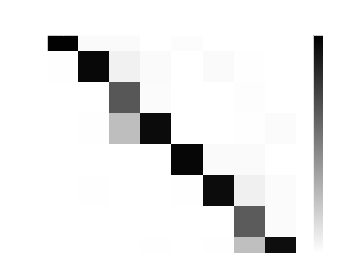

In [51]:
yorktown_cal_results = yorktown_cal_job.result()
yorktown_meas_fitter = CompleteMeasFitter(yorktown_cal_results, state_labels)
yorktown_meas_fitter.plot_calibration()

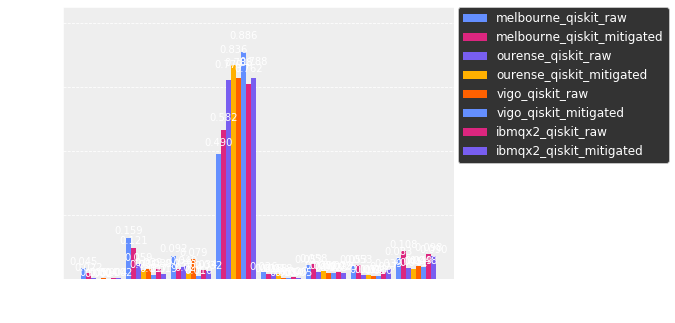

In [58]:
measurement_filters = {
    'melbourne': melbourne_meas_fitter.filter,
    'ourense': ourense_meas_fitter.filter,
    'vigo': vigo_meas_fitter.filter,
    'ibmqx2': yorktown_meas_fitter.filter
}
qiskit_results = {
    'melbourne': melbourne_result,
    'ourense': ourense_result,
    'vigo': vigo_result,
    'ibmqx2': ibmqx2_result,
}
device_names = ['melbourne', 'ourense', 'vigo', 'ibmqx2']

counts = []
for d in device_names:
    counts.append(qiskit_results[d].get_counts(qiskit_rccx_circuit))
    counts.append(measurement_filters[d].apply(qiskit_results[d]).get_counts(qiskit_rccx_circuit))

legends = [d+'_'+s for d in device_names for s in ['qiskit_raw', 'qiskit_mitigated']]
plot_histogram(counts, legend=legends)



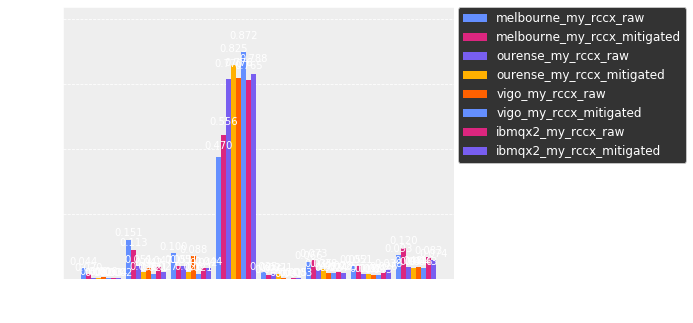

In [59]:
counts = []
for d in device_names:
    counts.append(qiskit_results[d].get_counts(my_rccx_circuit))
    counts.append(measurement_filters[d].apply(qiskit_results[d]).get_counts(my_rccx_circuit))

legends = [d+'_'+s for d in device_names for s in ['my_rccx_raw', 'my_rccx_mitigated']]
plot_histogram(counts, legend=legends)

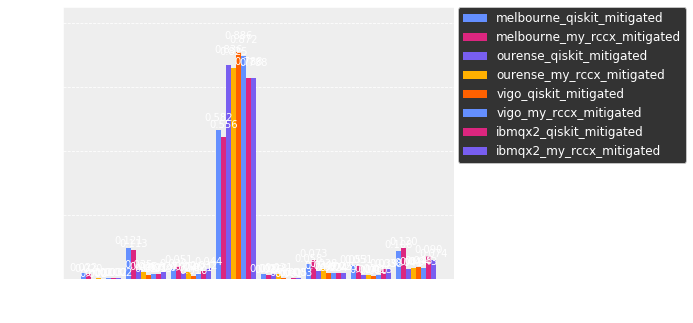

In [60]:
measurement_filters = {
    'melbourne': melbourne_meas_fitter.filter,
    'ourense': ourense_meas_fitter.filter,
    'vigo': vigo_meas_fitter.filter,
    'ibmqx2': yorktown_meas_fitter.filter
}
qiskit_results = {
    'melbourne': melbourne_result,
    'ourense': ourense_result,
    'vigo': vigo_result,
    'ibmqx2': ibmqx2_result,
}
device_names = ['melbourne', 'ourense', 'vigo', 'ibmqx2']

counts = []
for d in device_names:
    counts.append(measurement_filters[d].apply(qiskit_results[d]).get_counts(qiskit_rccx_circuit))
    counts.append(measurement_filters[d].apply(qiskit_results[d]).get_counts(my_rccx_circuit))

legends = [d+'_'+s for d in device_names for s in ['qiskit_mitigated', 'my_rccx_mitigated']]
plot_histogram(counts, legend=legends)